In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation
import os #checking status of requested files

import matplotlib  #ploting
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.notebook import trange

In [ ]:
from skimage.transform import downscale_local_mean, resize

## Compile Transitfit library  
in the utils folder run:  
f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'  

In [2]:
import spgen as spgen #Python Routines for SpecGen Routines and wrappers for fast-Transit-model.

In [3]:
# For Debuging
import importlib

In [409]:
importlib.reload(spgen) 

<module 'spgen' from '/home/rowe/Documents/jwst/jwst-mtl/SOSS/specgen/spgen.py'>

## Notebook Parameters  
These parameters set up the work environment.

In [5]:
workdir='/data/JWST/' #root folder for local files

## Model Parameters  
todo:  
- add rprstype to get planetmodel type

In [6]:
pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

Not found:  rprstype1 9 rprstype 1
Linenumber:  42


## Get Instrument Response 

In [7]:
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
response=spgen.readresponse(response_file)

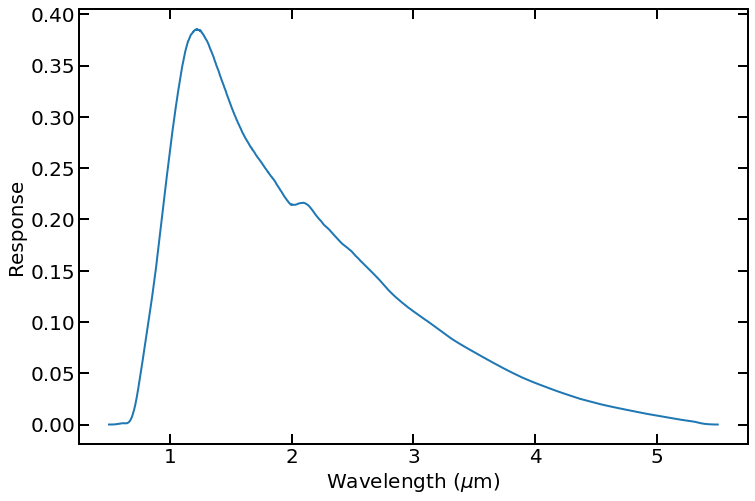

In [8]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(response.wv/10000,response.response[1],lw=2)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Response')

plt.show()

## Read in Stellar Atmosphere
todo: 
- ~~read in limb-darkening coefficients~~

In [9]:
starmodel_wv,starmodel_flux,ld_coeff=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

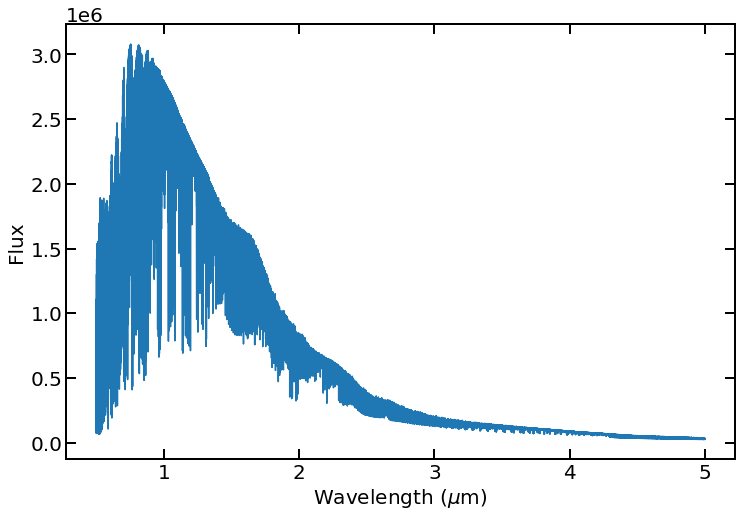

In [10]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(starmodel_wv/10000,starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

plt.show()

## Read in Planet atmosphere  

In [11]:
pmodeltype=2  ## Needs to be added as model parameter.  
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(workdir+pars.pmodelfile[0],pmodeltype)

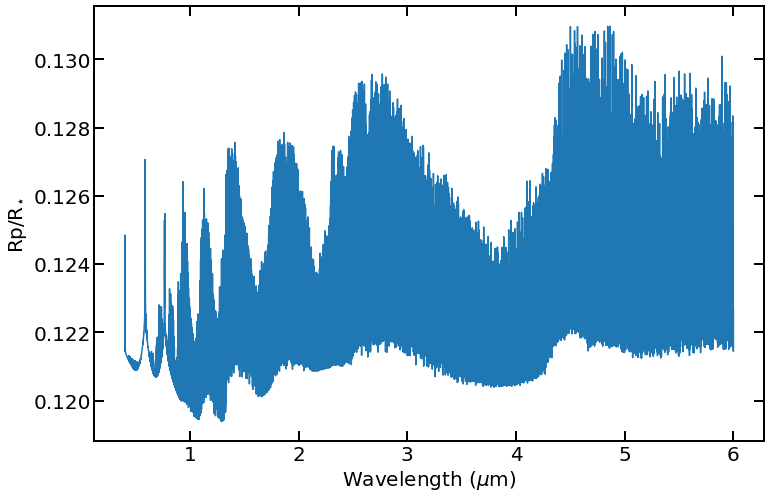

In [12]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(planetmodel_wv/10000,planetmodel_rprs)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

In [13]:
print(spgen.p2w.__doc__)

Usage: w=p2w(p,noversample,ntrace) Converts x-pixel (p) to wavelength (w)
    Inputs:
      p : pixel value along dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      w : wavelength (A)
    


In [14]:
print(spgen.w2p.__doc__)

Usage: p=w2p(w,noversample,ntrace) Converts wavelength (w) to x-pixel (p)
    Inputs:
      w : wavelength (A)
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      p : pixel value along dispersion axis (float) on oversampled grid.

    


In [15]:
print(spgen.ptrace.__doc__)

given x-pixel, return y-position based on trace
    Usage:
    py = ptrace(px,noversample,ntrace)

    Inputs:
      px : pixel on dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      py : pixel on spatial axis (float) on oversampled grid.
    


## Resample Spectra onto a common grid  
Todo:  
- ~~common wavelength grid~~
- ~~bin starflux~~
- ~~bin planet r/R*~~
- ~~bin limb-darkening~~
- add interpolation when resolution is insufficient

In [16]:
#Get wavelength spacing to use for resampling
norder=1
dw,dwflag=spgen.get_dw(starmodel_wv,planetmodel_wv,norder,pars)
print(dw,dwflag)

0.9599941999986186 0


In [40]:
norder=1
bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs=\
  spgen.resample_models(dw,starmodel_wv,starmodel_flux,ld_coeff,planetmodel_wv,planetmodel_rprs,norder,pars)

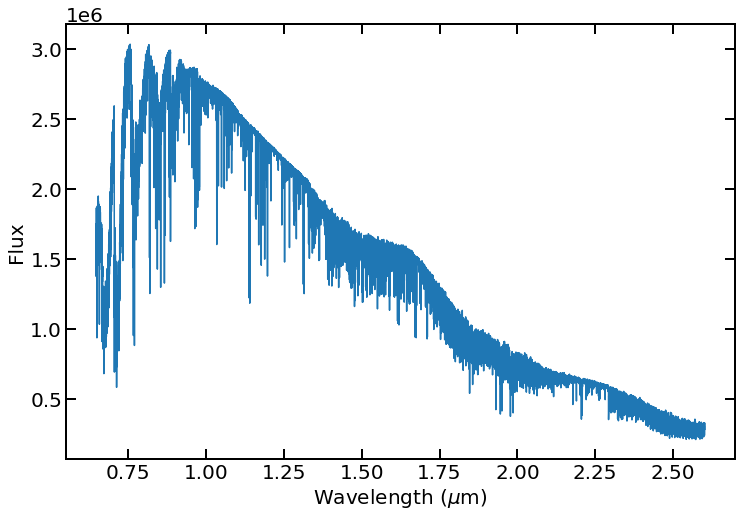

In [41]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_starmodel_wv/10000,bin_starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

plt.show()

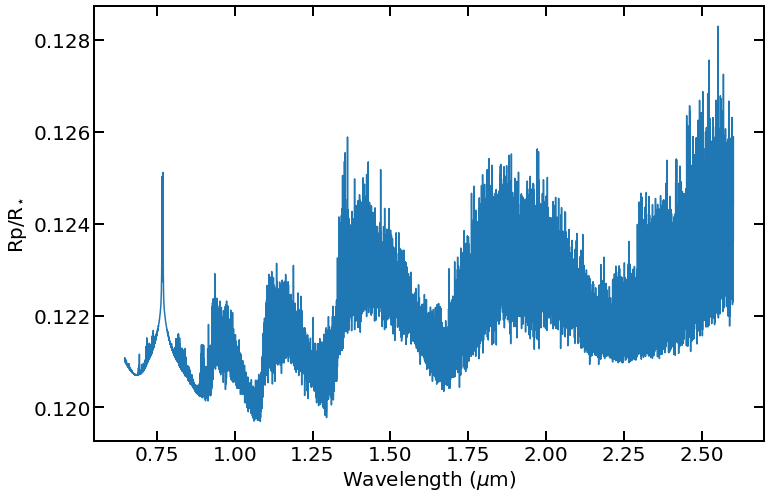

In [42]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_planetmodel_wv/10000,bin_planetmodel_rprs)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

## Transit Model  
todo:  
- ~~create solin array from pars.sol for each wavelength.~~
- ~~calculate transit-depth at each wavelength~~
- requires integration time
- time should be an array.
- add multiplanet capabilities

In [43]:
#Static Solution parameters (LD,r/R* and TED are wavelength dependent)
#This is a single planet example
solin=np.zeros(8+10*pars.nplanet) #TF5 style transit solution array
time=0.0    #time
itime=0.0001 #integration time (days)
solin[0]=np.copy(pars.sol[0]) #Mean stellar density
solin[8]=np.copy(pars.sol[1]) #EPO
solin[9]=np.copy(pars.sol[2]) #Period
solin[10]=np.copy(pars.sol[3]) #Impact parameter
solin[12]=np.copy(pars.sol[4]) #ECW
solin[13]=np.copy(pars.sol[5]) #ESW
solin[14]=np.copy(pars.sol[6]) #KRV
solin[16]=np.copy(pars.sol[7]) #ELL
solin[17]=np.copy(pars.sol[8]) #ALB 

## Generate unconvolved image with n=1 order  
todo:
- ~~use resampled star,planet models~~
- ~~use transit model~~  
- scale total flux on detector using ETC output

In [44]:
#array to hold synthetic image
xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample

pixels=np.zeros((xmax,ymax))

norder=1 #Order to use.

#interpolate over response and quantum yield
response_spl = interpolate.splrep(response.wv, response.response[1], s=0)
quantum_yield_spl  = interpolate.splrep(response.wv, response.quantum_yield, s=0)
rmax=np.max(response.wv)
rmin=np.min(response.wv)

#Generate Transit Model
npt=len(bin_starmodel_wv) #number of wavelengths in model
time_array=np.ones(npt)*time   #Transit model expects array
itime_array=np.ones(npt)*itime #Transit model expects array
rdr_array=np.ones((1,npt))*bin_planetmodel_rprs #r/R* -- can be multi-planet
tedarray=np.zeros((1,npt)) #secondary eclipse -- can be multi-planet
planet_flux_ratio=spgen.transitmodel (solin, time_array,\
                        bin_ld_coeff[:,0], bin_ld_coeff[:,1], bin_ld_coeff[:,2],bin_ld_coeff[:,3],\
                        rdr_array,tedarray,itime=itime_array)

for k in range(bin_starmodel_wv.shape[0]):
    
    w=bin_starmodel_wv[k]
    i=spgen.w2p(w,pars.noversample,norder)
    j=spgen.ptrace(i,pars.noversample,norder)
    
    if (i<=xmax+1) & (i>=0) & (j<=ymax+1) & (j>=0): #check if pixel is on grid
        
        if w < rmax and w > rmin:
            response_one = interpolate.splev(w, response_spl, der=0)
            quantum_yield_one = interpolate.splev(w, quantum_yield_spl, der=0)
        else:
            response_one = 0
            quantum_yield_one = 0
        flux=planet_flux_ratio[k]*bin_starmodel_flux[k]*response_one*quantum_yield_one
        pixels=spgen.addflux2pix(i,j,pixels,flux)


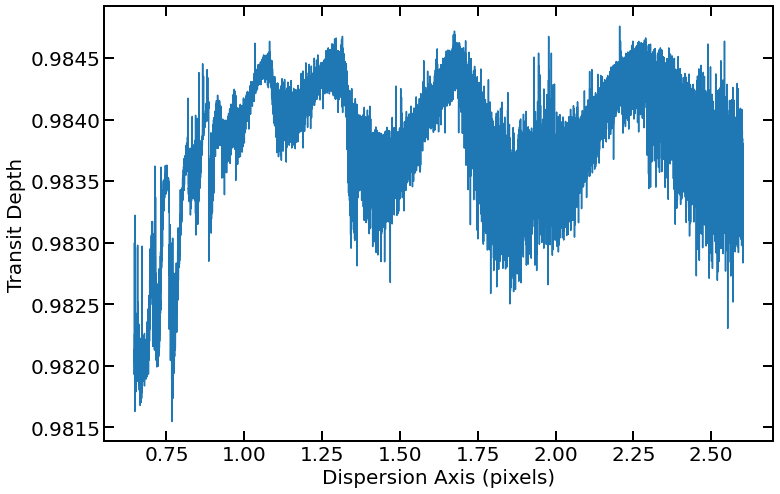

In [45]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_starmodel_wv/10000,planet_flux_ratio) #Plot the sum of each column

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('Transit Depth')

plt.show()

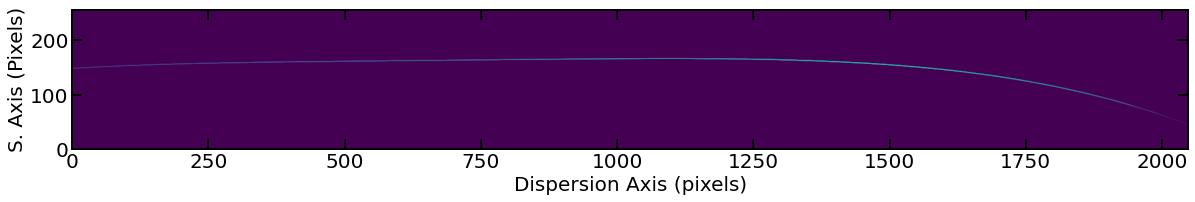

In [145]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.imshow(np.transpose(np.sqrt(pixels)))
ax.axis((0,pixels.shape[0],0,pixels.shape[1]))

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('S. Axis (Pixels)')
plt.show()

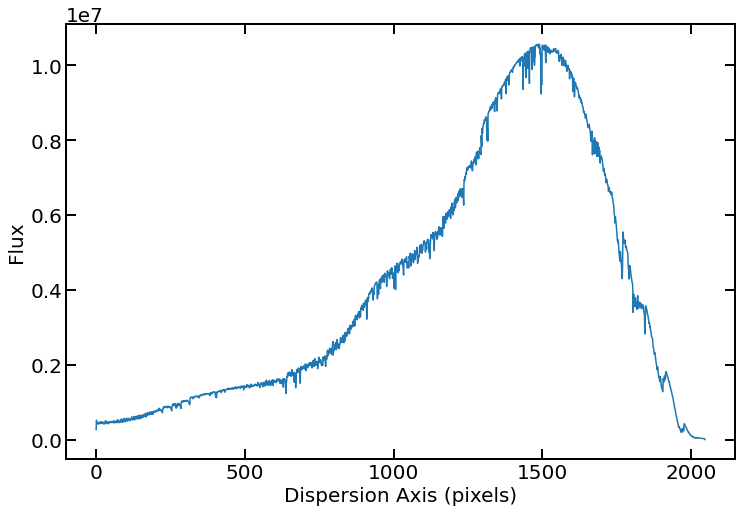

In [47]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(np.sum(pixels,axis=1),label='Column Sum') #Plot the sum of each column

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('Flux')

plt.show()

## Convolve Image with PSF  
todo:  
- ~~read in Kernel~~
- resize Kernels

In [410]:
#Read in Kernels
kernels,kernels_wv=spgen.readkernels(workdir)

In [412]:
import pyfftw
import multiprocessing
import scipy.signal
from matplotlib.colors import LogNorm
pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()

In [414]:
#resize Kernels 
#limit oversampling to be: 1<10
kernel_resize=[]
for k in kernels:
    kernel_resize.append(resize(k,(128*pars.noversample,128*pars.noversample)))

In [415]:
#Set up FFTW
cpixels=np.copy(pixels.T)
a = pyfftw.empty_aligned((cpixels.shape[0], cpixels.shape[1]), dtype='float64')
b = pyfftw.empty_aligned((kernel_resize[0].shape[0], kernel_resize[0].shape[1]), dtype='float64')
# Monkey patch fftpack with pyfftw.interfaces.scipy_fftpack
scipy.fftpack = pyfftw.interfaces.scipy_fftpack
scipy.signal.fftconvolve(a, b, axes=(0,1)) # We cheat a bit by doing the planning first
# Turn on the cache for optimum performance
pyfftw.interfaces.cache.enable()

In [420]:
#do the convolution
x=cpixels*0+1.0e-10
#wv_idx=0 #wavelength choice #Wavelength
for wv_idx in trange(len(kernels_wv)):
    a = np.copy(cpixels)
    b = np.copy(kernel_resize[wv_idx])
    x1=scipy.signal.fftconvolve(a, b, mode='same')
    wl=kernels_wv[wv_idx]
    dwl=0.05
    for i in range(x1.shape[1]):
        wlp=spgen.p2w(i,pars.noversample,norder)/10000.0
        fac=max(0.0,1.0-np.abs(wlp-wl)/dwl)
        #print(fac,wlp,wl,dwl)
        #input()
        x1[:,i]=x1[:,i]*fac
    x+=x1

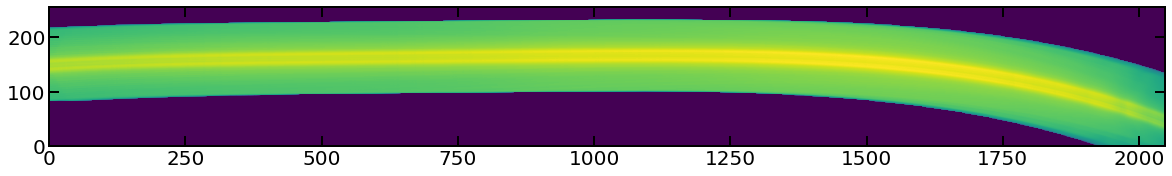

In [421]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

test=x

ax.imshow(test,norm=LogNorm())
ax.axis((0,test.shape[1],0,test.shape[0]))

plt.show()